In [ ]:
#import necessary libraries
# This code is for a machine learning model that predicts machine failure risk based on incoming data.
# Ensure you have the required libraries installed
%pip install imbalanced-learn,shap
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE  # ✅ SMOTE added
import matplotlib.pyplot as plt
import seaborn as sns

ERROR: Invalid requirement: 'imbalanced-learn,shap': Expected end or semicolon (after name and no valid version specifier)
    imbalanced-learn,shap
                    ^


Note: you may need to restart the kernel to use updated packages.


In [ ]:
#load the dataset
df = pd.read_csv("D:\predictive_maintenance.csv")

In [ ]:
#read the dataset
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [ ]:
#checking the unique product IDs
unique_products = df['Product ID'].unique()
print(f"Unique Product IDs: {unique_products}")
# Check for missing values
missing = df.isnull().sum()
print(f"Missing values in each column: \n{missing}")
#checking the failure types
failure = df['Failure Type'].value_counts()
print(f"\nFailure Type counts: \n{failure}\n")
df['Type'].value_counts()


Unique Product IDs: ['M14860' 'L47181' 'L47182' ... 'M24857' 'H39412' 'M24859']
Missing values in each column: 
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

Failure Type counts: 
Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64



Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

In [ ]:
#droping the unnecessary columns for better model performance
df.drop(columns=['UDI','Product ID','Failure Type'], inplace = True)

In [ ]:
#checking the dataset
df

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0
...,...,...,...,...,...,...,...
9995,M,298.8,308.4,1604,29.5,14,0
9996,H,298.9,308.4,1632,31.8,17,0
9997,M,299.0,308.6,1645,33.4,22,0
9998,H,299.0,308.7,1408,48.5,25,0


In [ ]:
# One-hot encode 'Type' column and drop first category to avoid multicollinearity
df=pd.get_dummies(df, columns = ['Type'], drop_first = True)
df


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,False,True
1,298.2,308.7,1408,46.3,3,0,True,False
2,298.1,308.5,1498,49.4,5,0,True,False
3,298.2,308.6,1433,39.5,7,0,True,False
4,298.2,308.7,1408,40.0,9,0,True,False
...,...,...,...,...,...,...,...,...
9995,298.8,308.4,1604,29.5,14,0,False,True
9996,298.9,308.4,1632,31.8,17,0,False,False
9997,299.0,308.6,1645,33.4,22,0,False,True
9998,299.0,308.7,1408,48.5,25,0,False,False


In [ ]:
#converting the boolean columns 'Type_L' and 'Type_M' to integers
df[['Type_L','Type_M']] = df[['Type_L','Type_M']].astype(int)
print(df.columns)
df


Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target',
       'Type_L', 'Type_M'],
      dtype='object')


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0,1
1,298.2,308.7,1408,46.3,3,0,1,0
2,298.1,308.5,1498,49.4,5,0,1,0
3,298.2,308.6,1433,39.5,7,0,1,0
4,298.2,308.7,1408,40.0,9,0,1,0
...,...,...,...,...,...,...,...,...
9995,298.8,308.4,1604,29.5,14,0,0,1
9996,298.9,308.4,1632,31.8,17,0,0,0
9997,299.0,308.6,1645,33.4,22,0,0,1
9998,299.0,308.7,1408,48.5,25,0,0,0


In [ ]:
#Splitting the dataset into features and target variable
X = df.drop('Target',axis=1)
y = df['Target']


In [ ]:
#train test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)


In [11]:
# Clean column names for XGBoost compatibility
def clean_column_names(df):
    df = df.copy()
    df.columns = (
        df.columns.str.replace('[\[\]<>]', '', regex=True)
                  .str.replace(' ', '_')
    )
    return df

In [ ]:

X_train = clean_column_names(X_train)
X_val = clean_column_names(X_val)
X_test = clean_column_names(X_test)

# ✅ Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize the XGBoost Classifier with key parameters
model = XGBClassifier(
    use_label_encoder=False,    # Avoid warning related to label encoding (not needed for numeric targets)
    eval_metric='logloss',      # Metric used to evaluate model performance during training
    scale_pos_weight=9.5,       # Helps handle class imbalance by giving more weight to the positive class
    random_state=42,            # Ensure reproducibility
)
# Train the model using resampled training data
# Also provide validation set for monitoring performance during training
model.fit(
    X_train_resampled, y_train_resampled,                                   # Balanced training data after applying SMOTE or similar technique
    eval_set=[(X_train_resampled, y_train_resampled), (X_val, y_val)],      # Validation data
    verbose=True  # Show progress                                           # Print training progress including evaluation metric at each boosting round
)

# Get evaluation results from the model
evals_result = model.evals_result()



In [ ]:
# Make predictions on the validation set using the trained XGBoost model
y_val_pred = model.predict(X_val)
# Calculate and print the accuracy score on the validation set
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
# Generate and print a detailed classification report showing precision, recall, F1-score, and support
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))


Validation Accuracy: 0.955
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      1932
           1       0.41      0.74      0.53        68

    accuracy                           0.95      2000
   macro avg       0.70      0.85      0.75      2000
weighted avg       0.97      0.95      0.96      2000



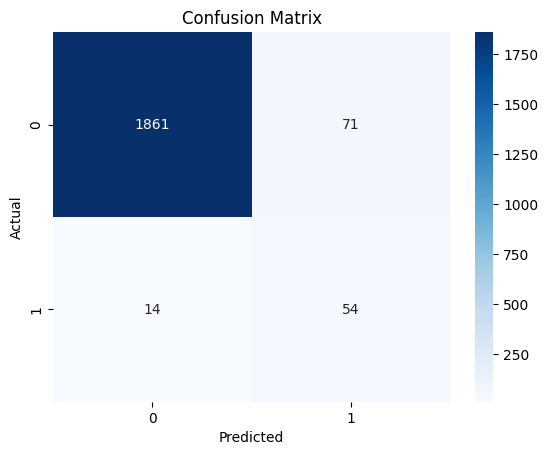

In [24]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Evaluate the trained model on the test set
# Predict labels for test data and compute performance metrics
y_pred = model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.9575
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      1932
           1       0.43      0.79      0.56        68

    accuracy                           0.96      2000
   macro avg       0.71      0.88      0.77      2000
weighted avg       0.97      0.96      0.96      2000



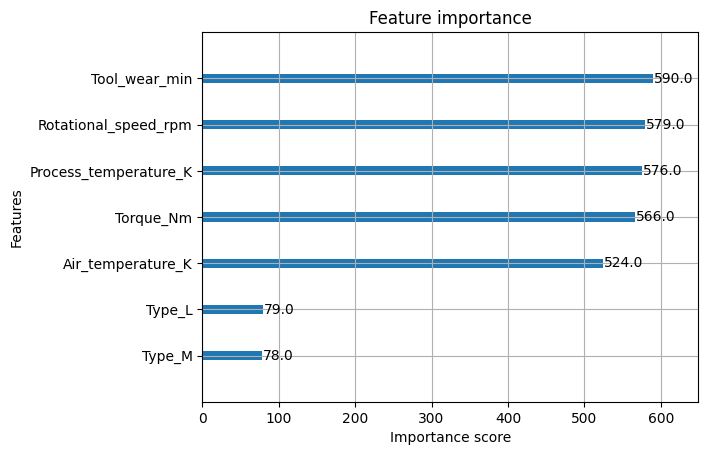

In [ ]:
# Visualize feature importance to understand which input features contribute most to the model's predictions
import xgboost as xgb

xgb.plot_importance(model)
plt.show()


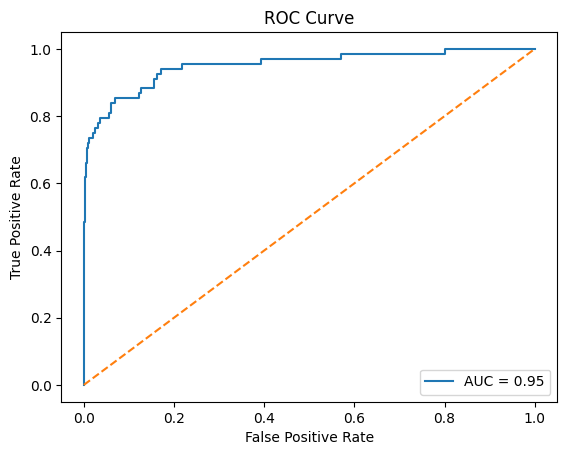

In [ ]:
# Plot ROC Curve
from sklearn.metrics import roc_curve, roc_auc_score

y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_probs):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


c:\Users\Malika sahifa samira\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


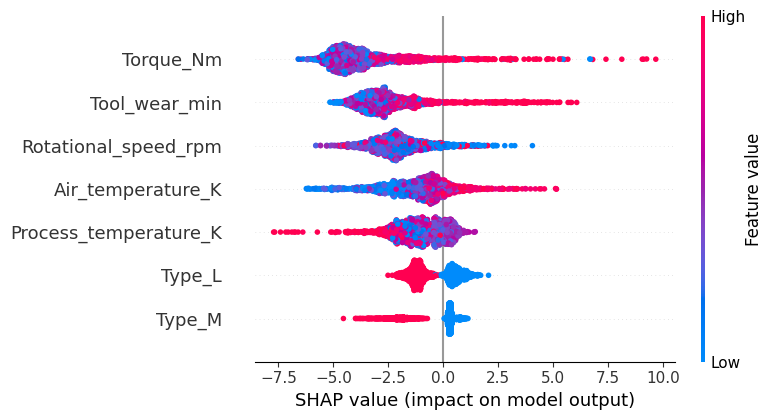

In [ ]:
# SHAP (SHapley Additive exPlanations) for model interpretability
# SHAP values help explain the output of machine learning models by quantifying the contribution of each feature to the prediction for each instance.
import shap
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)


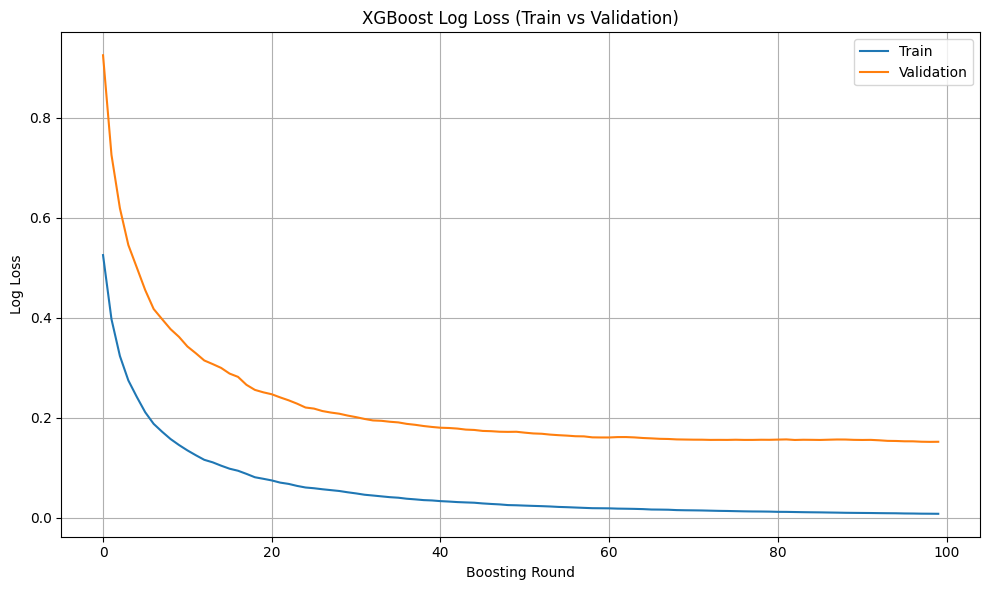

In [20]:
#Plot Training vs Validation Log Loss
epochs = len(evals_result['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Train')
plt.plot(x_axis, evals_result['validation_1']['logloss'], label='Validation')
plt.xlabel('Boosting Round')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss (Train vs Validation)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Save the trained model using joblib for later use
import joblib

# Save the model
joblib.dump(model, 'xgb_model.pkl')


['xgb_model.pkl']